# Offline analysis of a [mindaffectBCI](https://github.com/mindaffect) savefile

So you have successfully run a BCI experiment and want to have a closer look at the data, and try different analysis settings?  

Or you have a BCI experiment file from the internet, e.g. MOABB, and want to try it with the mindaffectBCI analysis decoder?  

Then you want to do an off-line analysis of this data!  

This notebook shows how to such a quick post-hoc analysis of a previously saved dataset.  By the end of this tutorial you will be able to:
 * Load a mindaffectBCI savefile
 * generate summary plots which show; the per-channel grand average spectrum, the data-summary statistics, per-trial decoding results, the raw stimulus-resonse ERPs, the model as trained by the decoder, the per-trial BCI performance plots.
 * understand how to use these plots to identify problems in the data (such as artifacts, excessive line-noise) or the BCI operation
 * understand how to change analysis parameters and the used classifier to develop improved decoders

In [1]:
import matplotlib.pyplot as plt
import copy
%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 8] # bigger default figures


import numpy as np
from sklearn.model_selection import GridSearchCV
from mindaffectBCI.decoder.analyse_datasets import decoding_curve_GridSearchCV, print_decoding_curves, plot_decoding_curves, datasets_decoding_curve_GridSearchCV, average_results_per_config
from mindaffectBCI.decoder.offline.load_mindaffectBCI  import load_mindaffectBCI
from mindaffectBCI.decoder.updateSummaryStatistics import plot_trial
from mindaffectBCI.decoder.preprocess import plot_grand_average_spectrum
from mindaffectBCI.decoder.preprocess_transforms import make_preprocess_pipeline
from mindaffectBCI.decoder.decodingCurveSupervised import print_decoding_curve, plot_decoding_curve
import mindaffectBCI.decoder.offline.datasets as datasets
from mindaffectBCI.decoder.utils import askloadsavefile

## Specify the save file you wish to analyse.

You can either specify:
 * the full file name to load, e.g. '~/Downloads/mindaffectBCI_200901_1154.txt'
 * a wildcard filename, e.g. '~/Downloads/mindaffectBCI*.txt', in which case the **most recent** matching file will be loaded.
 * `None`, or '-', in which case the most recent file from the default `logs` directory will be loaded.

In [2]:
# use the example dataset
loader = None
savefile = '../data/mindaffectBCI_cVEP_example.txt'
savefile = "G:/Shared drives/Data/experiments/BCI_speller/online_bci/s8/220825_1517/mindaffectBCI_online_bci_220825_1517.txt"

Comment the below cell to use a GUI picker to select the file for analysis

In [4]:
# Uncomment to manually pick the analysis file
# # select the file to load
# loader = None
# savefile = askloadsavefile()

## Load the *RAW*data

Load, with minimal pre-processing to see what the raw signals look like.  Note: we turn off the default filtering and downsampling with `stopband=None, fs_out=None` to get a true raw dataset.

It will then plot the grand-aver-spectrum of this raw data.  This plot shows for each EEG channel the signal power across different signal frequencies.   This is useful to check for artifacts (seen as peaks in the spectrum at specific frequencies, such as 50hz), or bad-channels (seen as channels with excessively high or low power in general.)

During loading the system will print some summary information about the loaded data and preprocessing applied. Including:
 * The filter and downsampling applied
 * The number of trails in the data and their durations
 * The trail data-slice used, measured relative to the trial start event
 * The EEG and STIMULUS meta-information, in terms of the array shape, e.g. (13,575,4) and the axis labels, e.g. (trials, time, channels) respectively. 

The loaded data is returned in a nd-array with shape:
 * `X_TSd` = (T=#Trails, S=#Samples, d=#electrodes)
 * `Y_TSy` = (T=#Trails, S=#Samples, y=#outputs)

Note: As we have many high-dimensional arrays in this analysis, as a shorthand many variable names use a dimension order post-fix notation to remind the reader of their structure.  Thus `X_TSd` implies this is a 3-dimensional array with order (Trials,Samples,channels) and `Y_TSy` implies (Trials,Samples,outputs).

Note: We use the concept of stimulus _outputs_, stimulus _levels_, and stimulus _events_, to represent the stimulus properties.   Briefly:
 1. _outputs_: we may have many different stimuli, such as keys on a virtual keyboard, or beep-tones in an auditory system.  Each different stimulus is generally represented as a unique output.
 2. _levels_: Over time some proprety of a stimulus output may vary, such as the brightness of a keyboard button, or the intensity of a beep sound.  This is encoded by having the level of the output vary over time also.  The meaning of different output level is something for the system designer, but by convention, level==0 means 'stimulus off' and higher levels tend to imply a 'stronger' stimulus intensity.
 3. _events_: When modeling the brains response to stimulus changes, we know it does not respond simply in proportion to the level changes, but in a more complex fashion.  For example, the brain may respond differently to stimulus _onset_ compared to stimulus _offset_.   To allow modeling of these effects, the raw stimulus information (i.e. levels and outputs) is transformed into _stimulus events_ where each event gets it's own brain response.  
 
 Note: _stimulus events_ may also have a 'level' to represent the intensity of the expected brain response, though in many cases they are purely binary.

In [3]:
if loader is not None: # use given loader
    oX_TSd, oY_TSy, ocoords = loader(savefile)
else:
    oX_TSd, oY_TSy, ocoords = load_mindaffectBCI(savefile, filterband=((0,.5),(45,65),(95,105),(145,155),(195,205)), offset_ms=(-3000,4000), fs_out=None)


In [4]:
X_TSd=oX_TSd.copy()
Y_TSy=oY_TSy.copy()
coords = copy.deepcopy(ocoords)
fs = ocoords[1]['fs']
ch_names = ocoords[2]['coords']
# output is: X=eeg, Y=stimulus, coords=meta-info about dimensions of X and Y
print("EEG: X({}){} @{}Hz".format([c['name'] for c in coords],X_TSd.shape,fs)) 
print("{}".format(ch_names))                           
print("STIMULUS: Y({}){}".format([c['name'] for c in coords[:-1]]+['output'],Y_TSy.shape))

EEG: X(['trial', 'time', 'channel'])(20, 4239, 16) @249.5632642874969Hz
['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'C1', 'Cz', 'C2', 'P3', 'Pz', 'P2', 'O1', 'Oz', 'O2', 'T3', 'T4']
STIMULUS: Y(['trial', 'time', 'output'])(20, 4239, 26)


Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot


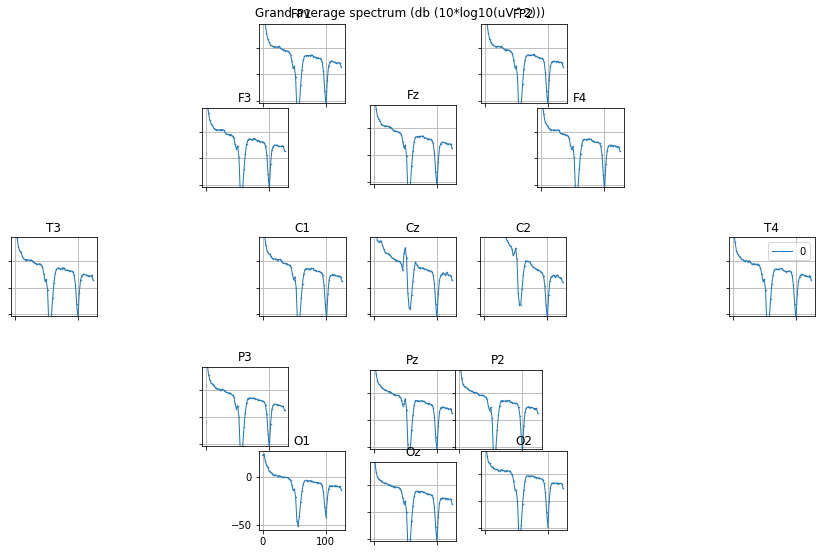

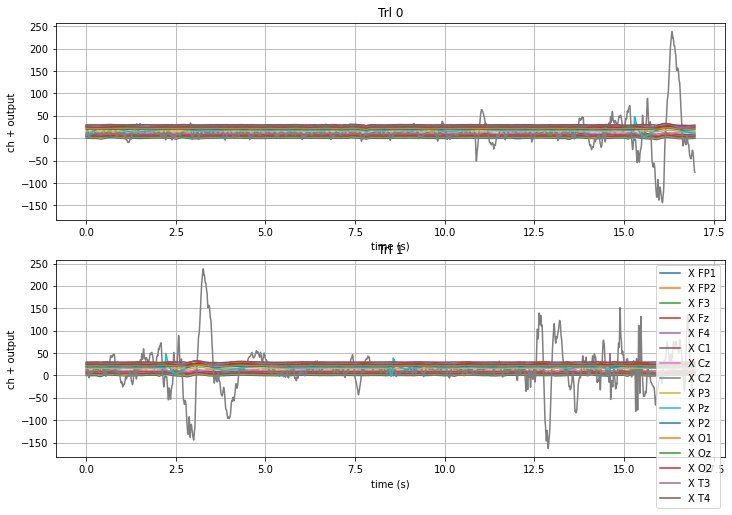

In [5]:
# Plot the grand average spectrum to get idea of the signal quality
plot_grand_average_spectrum(X_TSd, fs=fs, ch_names=ch_names, log=True)
plt.show()
# and a single trial as raw data, also to get an idea of signal quality
plot_trial(X_TSd[-2:,...], None, fs=fs, ch_names=ch_names)

## Reload the data, with standard preprocessing.

This time, we want to analysis the loaded data for the BCI signal.  Whilst we can do this after loading, to keep the analysis as similar as possible to the on-line system where the decoder only sees pre-processed data, we will reload wand apply the pre-processing directly.   This also has the benefit of making the datafile smaller. 

To reproduce the pre-processing done in the on-line BCI we will set the pre-processing to:
  * temporally filter the data to the BCI relevant range.  Temporal filtering is a standard technique to remove sigal frequencies which we know only contain noise.  For the noise-tag brain response we know it is mainly in the frequency range from 3 to about 25 Hz.  Thus, we specifcy a bandpass filter to only retain these frequencies with: 
  `stopband=(3,25,'bandpass')`
  * The orginal EEG is sampled 250 times per second.  However, the BCI relevant signal changes at most at 25 times per second, thus the EEG is sampled much more rapidly than needed -- so processing it takes undeeded computational resources.  Thus, we downsmaple the data to save some computation.  To avoid signal-artifacts, as a general 'rule of thumb' you should downsample to about 3 times your maximum signal frequency.  In this  case we use an output sample rate of 4 times, or 100 h with:
  `fs_out=100`

In [6]:
# force random seed for reproducibility
seed=0
import random
random.seed(seed)
np.random.seed(seed)

## Specify an analysis pipeline

To analysis the data we need to specify an analysis pipeline, consisting of one-or-more pre-processing steps and finishing with a classification algorithm.   Designing the right analysis pipeline is critical to the performance of the BCI so you should think carefully about how to do this correctly.

To specify the pipeline we use a syntax and design inspired by that used in Sci-Kit learns [transformer pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators).   The basic idea is that you can specify a list of `Transformer` objects which will be called in order to 'transform' the incomming data, into data appropriate for classification.  To allow for fitting of the transformation to the particular properties of the incomming data, each transformer has a:
 * `fit` method, which is where some `X` (+`y`) training data is used to estimate the best parameters to transform the data
 * `transform` method, which is where the previously fitted parameters are used to transform a new piece of `X` data.
 
Unfortunately, the base sklearn transformers only allowed to modify the input `X` data, but not the trial targets `Y`.  This is a sever limitation for the type of sequence-to-sequence problems we study here, where we are trying to map from measured EEG data to input stimulus properties or tasks.  For example, when resampling the data one needs to resample both X and Y to maintain alignment of the info.   To overcome this issue, we have extended the pipeline specification to include an additional:
 * `modify` method, which is where the previously fitted parameters are used to transform a new piece of data `X` and associated targets `y`

As a further enhancement over the base sklearn specificiation, a utility function `make_preprocess_pipeline` is provided to easily allow pipeline specification in `.json` configuration files, the transformer class to use can be given as a string class name (fully qualified if needed) and a dictionary of arguments to pass to the constructor.

In this way a simple pipeline, consisting of a:
  1. Filtering, 2-25Hz and downsampling to 100Hz.  `['ButterFilterAndResampler',{'stopband':[2,25,'bandpass'], 'fs_out':100}]`
  2. Target encoding for only the rising edges (_onset_) and falling edges (_offset_) of the stimulus. `['TargetEncoder',{'evtlabs',['onset','offset']}]`
  3. Classification with the CCA decoder, with a 350ms response estimate. `['MultiCCA',{'tau_ms':350}]`
Can be specified as:

In [9]:
fs_out=100
pipeline=[
    ['ButterFilterAndResampler',{'filterband':[2,25,'bandpass'], 'fs_out':fs_out}],
    ['TargetEncoder',{'evtlabs':('oneset','offset')}],
    ['MultiCCA',{'tau_ms':350}],
]

Unfortunately, this pipeline won't yet work -- as the filter and downsampler doesn't know the sample rate of the input data.   We could provide this directly with an additional `'fs':100` argument to the stage.  However, this quickly becomes cumbersome as we have to manually track the sample rate through the pipeline.  

Insteady, as a second enhancement to ease use with time-series data, is to allow the annotation of input data with meta-information.  In particular, the data sample rate is commonly attached to the incomming `X` data and updated appropriately during the pipeline application.  This removes the need to specify this meta-info during the pipeline construction.  

To do this we use the `MetaInfoAdder` stage to add arbitary meta-info to the `X` data, by wrapping a numpy array with an `InfoArray` from the utils.py file.   To do this we add a stage: `['MetaInfoAdder',{'info':{'fs':fs}}]`

Adding this our final working pipeline is:

In [7]:
fs_out=180
pipeline=[
    ['MetaInfoAdder',{'info':{'fs':fs, 'ch_names':ch_names}}],
    ['ButterFilterAndResampler',{'filterband':[3,25,'bandpass'], 'fs_out':fs_out}],
    'BadChannelRemover',
    ['TargetEncoder',{'evtlabs':('onset','offset')}],
    ['MultiCCA',{'tau_ms':450}],
    #['MultiCCACV',{'tau_ms':550,'inner_cv_params':{'rank':[1]}}],
    #['BwdLinearRegressionCV:clsfr',{"tau_ms":550,"inner_cv_params":{"reg":[1e-3,1e-2,1e-1,.2,.3,.9]}}]
    #['FwdLinearRegressionCV:clsfr',{"tau_ms":550,"inner_cv_params":{"reg":[1e-3,1e-2,1e-1]}}]
]

To create a functional pipeline from this specification we use the `make_preprocess_pipeline` function, and then print the result to check if has been specified correctly.

In [8]:
ppp = make_preprocess_pipeline(pipeline)
print(ppp)

PreprocessPipeline(stages=[('metainfoadder',
                            MetaInfoAdder(info={'ch_names': ['FP1', 'FP2', 'F3',
                                                             'Fz', 'F4', 'C1',
                                                             'Cz', 'C2', 'P3',
                                                             'Pz', 'P2', 'O1',
                                                             'Oz', 'O2', 'T3',
                                                             'T4'],
                                                'fs': 249.5632642874969})),
                           ('butterfilterandresampler',
                            ButterFilterAndResampler(filterband=[3, 25,
                                                                 'bandpass'],
                                                     fs_out=180)),
                           ('badchannelremover', BadChannelRemover()),
                           ('targetencoder',
                         

*Aside: currently the following transformer classes are availble:*

In [9]:
import inspect
import mindaffectBCI.decoder.preprocess_transforms
for name, obj in inspect.getmembers(mindaffectBCI.decoder.preprocess_transforms):
    if inspect.isclass(obj) and 'preprocess_transforms' in obj.__module__ :
        print('{}\n{}'.format(obj, obj.__doc__))

<class 'mindaffectBCI.decoder.preprocess_transforms.Abs'>
square X to a power 
<class 'mindaffectBCI.decoder.preprocess_transforms.AdaptiveChannelPowerStandardizer'>
Incremental streaming tranformer to channel power normalization in an input stream
    
<class 'mindaffectBCI.decoder.preprocess_transforms.AdaptiveSpatialWhitener'>
Incremental streaming tranformer to channel power normalization in an input stream
    
<class 'mindaffectBCI.decoder.preprocess_transforms.BadChannelInterpolator'>
bad channel interpolator
    
<class 'mindaffectBCI.decoder.preprocess_transforms.BadChannelRemover'>
bad channel remover
    
<class 'mindaffectBCI.decoder.preprocess_transforms.BlockCovarianceMatrixizer'>
transform features to cross feature covariance matrices
    
<class 'mindaffectBCI.decoder.preprocess_transforms.ButterFilterAndResampler'>
Incremental streaming transformer for downsampling data transformations
    
<class 'mindaffectBCI.decoder.preprocess_transforms.ChannelPowerStandardizer'>


This pipeline is now a valid sklear Estimator and can be used directly in any method which takes an estimator.  In particular we can use the pipeline directly as:

In [10]:
ppp.fit(X_TSd.copy(),Y_TSy.copy())

PreprocessPipeline(stages=[('metainfoadder',
                            MetaInfoAdder(info={'ch_names': ['FP1', 'FP2', 'F3',
                                                             'Fz', 'F4', 'C1',
                                                             'Cz', 'C2', 'P3',
                                                             'Pz', 'P2', 'O1',
                                                             'Oz', 'O2', 'T3',
                                                             'T4'],
                                                'fs': 249.5632642874969})),
                           ('butterfilterandresampler',
                            ButterFilterAndResampler(filterband=[3, 25,
                                                                 'bandpass'],
                                                     fs_out=180)),
                           ('badchannelremover', BadChannelRemover()),
                           ('targetencoder',
                         

To visualize the final fitted model, we extract the last pipeline stage, with `ppp.stages[-1]`, the the estimator object as the 2nd slot of the tuple, and then ask the estimator object to plot itself with:

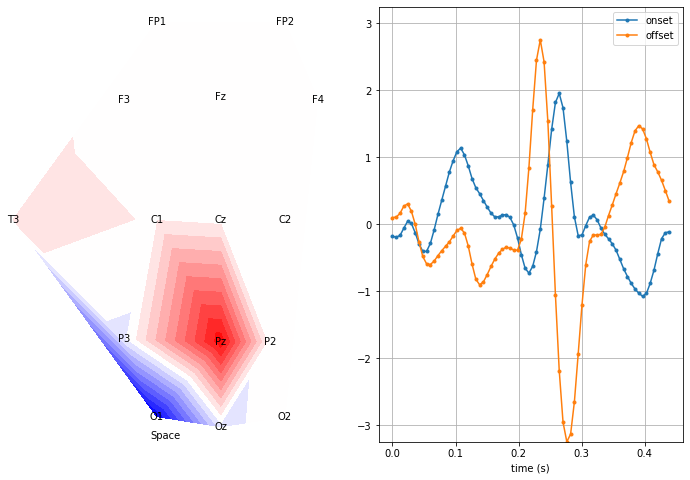

In [11]:
clsfr = ppp.stages[-1]
ppp.stages[-1][1].plot_model(ch_names=ch_names,plot_pattern=False)

## Pipeline debugging

Pipelines can transform the data in lots of interesting ways.  

To make it easier to debug this, a `TrialPlotter` transformer is provided, which as it's name implies makes a plot of the current `X`,`Y` data, so you can sanity check if it still looks fine.  By default this only plots the first trial, the first time it is called, so you can use without too much computational impact.  To use just insert the stage in your pipeline.  

The `TrialPlotter` gives a view of the single-trial data (and targets), to get a view of the per-class information you can use the `ClassAverPlotter`, which as the name implies will instead of plotting a single trial, plot the cross trial average for each of the classes in the `y` data.  If the meta-information is updated correctly this will also provide labels for the classes and correct units / labels on the axes.

For example to debug the above pipeline use:

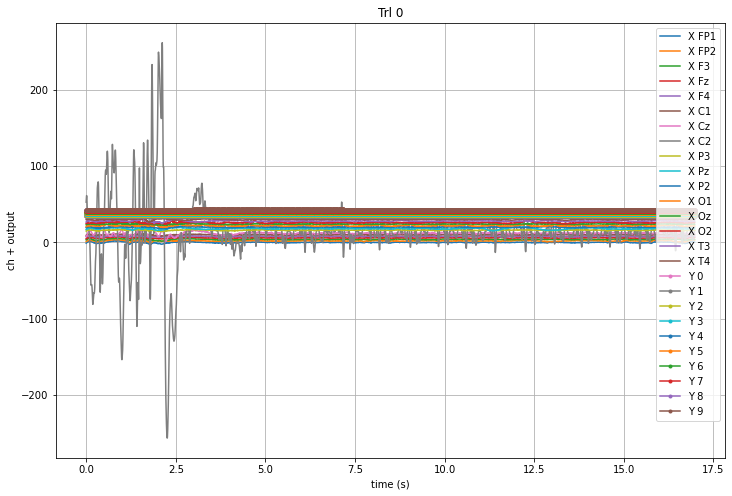

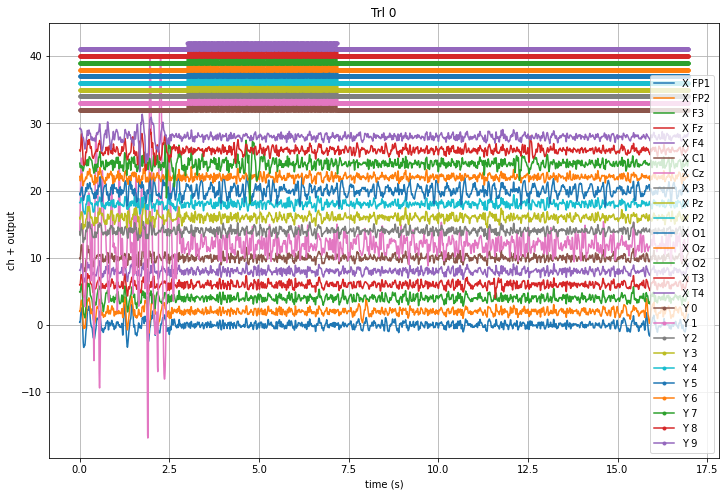

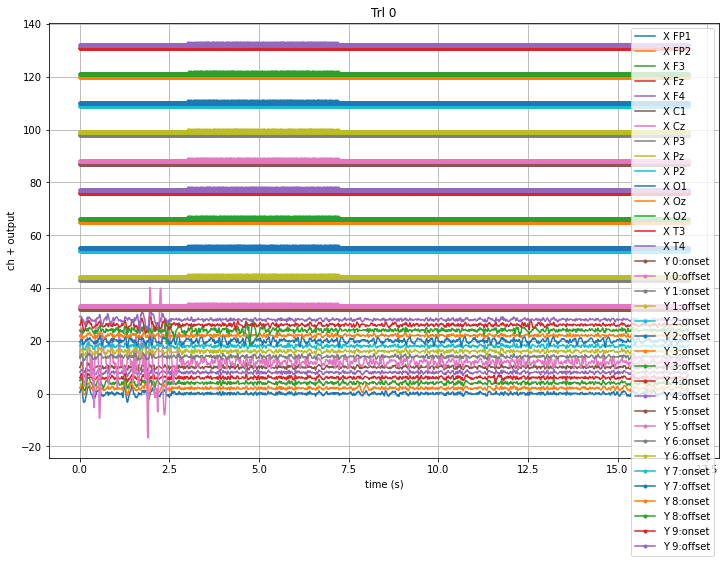

Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot
Not enough room between points to make plot


PreprocessPipeline(stages=[('metainfoadder',
                            MetaInfoAdder(info={'ch_names': ['FP1', 'FP2', 'F3',
                                                             'Fz', 'F4', 'C1',
                                                             'Cz', 'C2', 'P3',
                                                             'Pz', 'P2', 'O1',
                                                             'Oz', 'O2', 'T3',
                                                             'T4'],
                                                'fs': 249.5632642874969})),
                           ('trialplotter',
                            TrialPlotter(fig=<Figure size 864x576 with 1 Axes>)),
                           ('badchannelremover', BadChannelRemover()),
                           ('butterfilterandresampler',
                            ButterFilterAndResampler(filter...
                            TrialPlotter(fig=<Figure size 864x576 with 1 Axes>)),
                

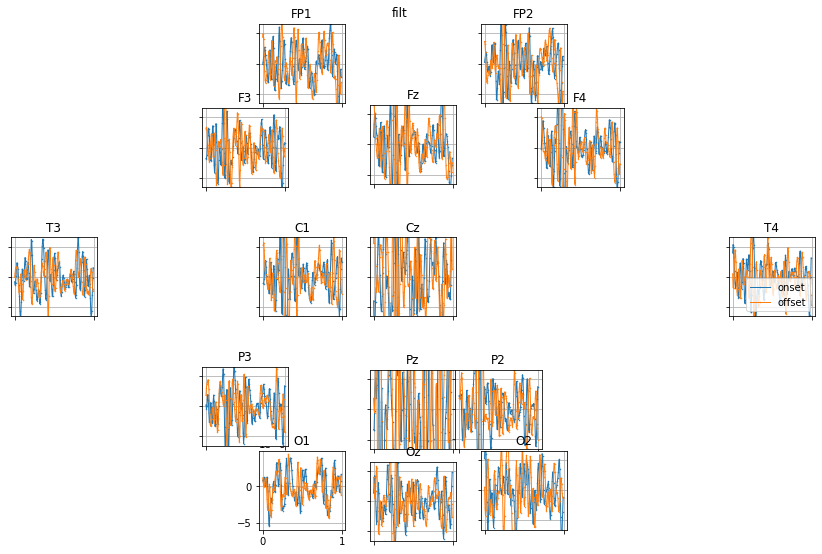

In [12]:
X_TSd = oX_TSd.copy()
Y_TSy = oY_TSy.copy()
coords = copy.deepcopy(ocoords)

#ch_names = ["TP10","P6","T8","F8","P4","CP6","C4","FC6","F4","FP2","POz","FP1","AFz","Fz","FC1","FC2","Cz","CP1","CP2","TP9","P7","T7","F7","CP5","FC5","P3","C3","F3"]
fs_out=180
debug_pipeline=[
    ['MetaInfoAdder',{'info':{'fs':fs, 'ch_names':ch_names}}],  "TrialPlotter",
    'BadChannelRemover',
    ['ButterFilterAndResampler',{'filterband':[3,25,'bandpass'], 'fs_out':fs_out}], "TrialPlotter",
    #['TimeShifter',{'timeshift_ms':0}],
    ['TargetEncoder',{'evtlabs':("onset","offset")}], "TrialPlotter",
    ['ClassAveragePlotter',{"tau_ms":1000, "suptitle":"filt"}],
    ['MultiCCA',{'tau_ms':450, 'offset_ms':0, 'temporal_basis':'winfourier2,8'}],
    #['MultiCCACV',{'tau_ms':500, "outputscore":"ip", "inner_cv_params":{"rank":(1,2,3,5)}}],
    #['LinearLogisticRegression',{'tau_ms':1000}],
    #['LinearLogisticRegressionCV',{'tau_ms':1000, "inner_cv_params":{"C":[8**v for v in [-8,-6,-4,-2,-1,0,1,2,4]]}}],
    #['BwdLinearRegression',{'tau_ms':1000}],
]
ppp = make_preprocess_pipeline(debug_pipeline)
ppp.fit(X_TSd.copy(),Y_TSy.copy())

To visualize the final fitted model, we extract the last pipeline stage, with `ppp.stages[-1]`, the the estimator object as the 2nd slot of the tuple, and then ask the estimator object to plot itself with:

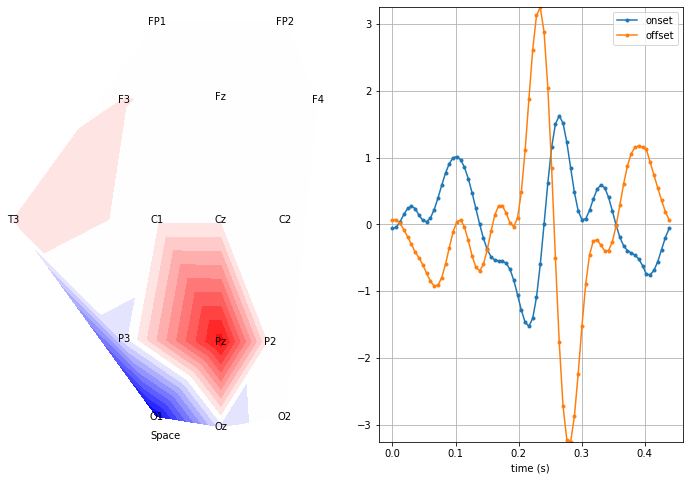

In [13]:
clsfr = ppp.stages[-1]
ppp.stages[-1][1].plot_model(ch_names=ch_names,plot_pattern=False)

To assess the quality of a model fit to the data you can use the `score` method.  Where higher values are prefered, and the max value is 1 for a perfect classifier.

In [14]:
score = ppp.score(X_TSd,Y_TSy)
print("Score = {}".format(score))

Score = 0.6628450106157112


To apply the pipeline only until the last stage, i.e. stopping just before the classifier use, and plot an example trail use:

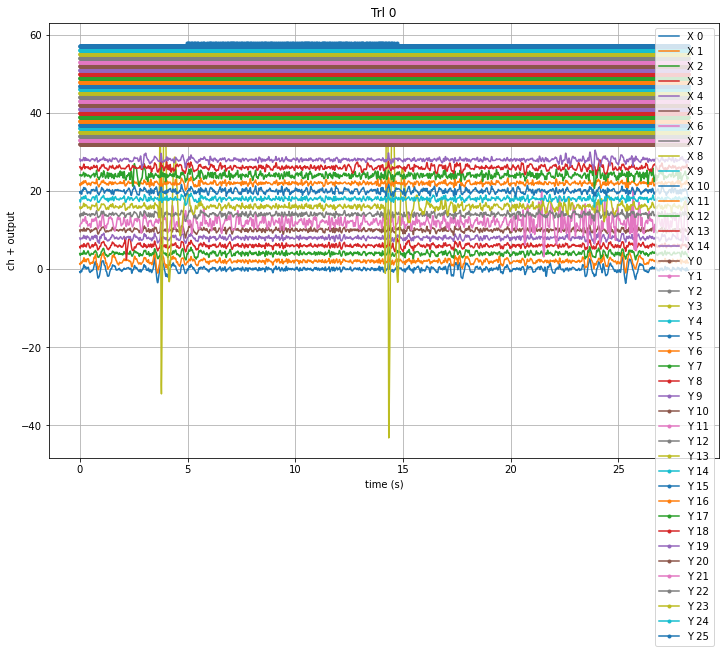

In [15]:
Xpp, Ypp = ppp.modify(X_TSd,Y_TSy, until_stage=-1)
plot_trial(Xpp[-1:,...],Ypp[-1:,...,0],fs=100)

This is particularly useful, for computing alternative statistics for the classifier performance. 
For example a confusion matrix:

Note: for this classifier, a relatively poor confusion matrix is expected -- as the non-stationarities in the data and the relatively low bit-rate per stimulus event mean low classification rates have a small effect on the decoding curve.

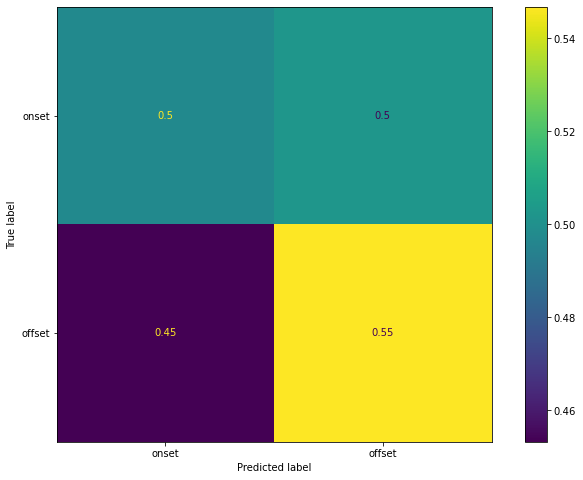

In [16]:
ppp.stages[-1][1].plot_confusion_matrix(Xpp,Ypp,cv=5)

Or a decoding curve:

Note: the p-values are *not* scaled correctly here as we do not use the cross-validation technique to scale them correctly... This function will be added later.

MultiCCA(tau_ms=450, temporal_basis='winfourier2,8')
Int Lens:..............................

            IntLen   376   753  1036  1413  1789  2072  2449  2826 
              Perr  1.00  0.45  0.25  0.20  0.20  0.20  0.20  0.20   AUDC 37.3
         Perr(est)  1.00  0.63  0.39  0.29  0.31  0.28  0.27  0.28   PSAE 27.2
           StopErr  0.75  0.30  0.30  0.30  0.25  0.20  0.20  0.20   AUSC 35.7
     StopThresh(P)  0.88  0.65  0.37  0.29  0.23  0.23  0.23  0.28   SSAE 17.6



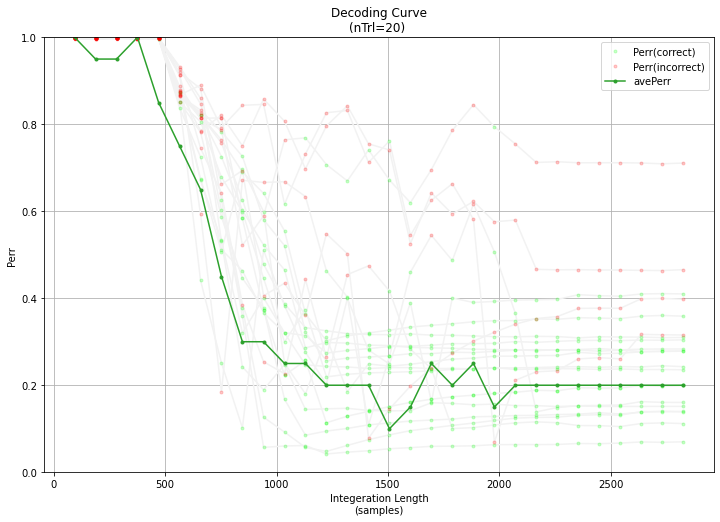

In [17]:
print(ppp.stages[-1][1])
dc = ppp.stages[-1][1].plot_decoding_curve(Xpp,Ypp,cv=5,nvirt_out=-20)

## Hyper-parameter testing

On of the main advantages of the pipeline framework is that it allows you to easily try different settings for the various pipeline parameters.  For example to try different filter settings, or different classifier settings.  This can be achieved using either the conventional sklearn [model-selection routines](https://scikit-learn.org/stable/model_selection.html), such as `GridSearchCV`, or ones specially developed for this type of sequence2sequence problem which give more detailed output information.

To use either technique, we first need to specify the *list* of hyper-parameters we which to test.  The general format for this is `pipeline_stage_name__parameter_name`, where *two underscores* `__` are used to separate the stage-name from the parameter name, e.g. to specify the response length of the multi-cca classifier, you would use: `multicca__tau_ms=[100,200,300]`.  

Note: By default the pipeline stage name is the _LOWER CASE_ version of the class name.  However, you can give an explicit stage name by specifying it after the class name with a semi-colon.  For example to use the name 'clsfr' for the final stage you can use: `['MultiCCA:clsfr',{'tau_ms':450}]`

If more than one list of parameters is given, then all possible combinations will be tried.

Thus, to try different values for the clsfr response length using GridSearchCV you can use.

Note: this will the settings/folds in parallel on multiple cores, and provide a final summary for each configuration as the *average score* over the cross-validation folds.

In [18]:
pipeline=[
    ['MetaInfoAdder',{'info':{'fs':fs}}],
    ['ButterFilterAndResampler',{'filterband':[3,25,'bandpass'], 'fs_out':100}],
    ['TargetEncoder',{'evtlabs':('onset','offset')}],
    ['MultiCCA',{'tau_ms':450}],
]

tuned_parameters=dict(
    multicca__tau_ms=[200, 300, 350, 400, 500, 600]
)

In [19]:
ppp = make_preprocess_pipeline(pipeline)

cv_ppp = GridSearchCV(ppp, tuned_parameters, n_jobs=-1, cv=5, verbose=2)
cv_ppp.fit(X_TSd, Y_TSy)
print("CVOPT:\n\nBest:\n{} = {:5.3f}\n".format(cv_ppp.best_params_, cv_ppp.best_score_))
means = cv_ppp.cv_results_['mean_test_score']
stds = cv_ppp.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cv_ppp.cv_results_['params']):
    print("{:5.3f} (+/-{:5.3f}) for {}".format(mean, std * 2, params))
print()

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CVOPT:

Best:
{'multicca__tau_ms': 400} = 0.613

0.059 (+/-0.138) for {'multicca__tau_ms': 200}
0.602 (+/-0.465) for {'multicca__tau_ms': 300}
0.600 (+/-0.469) for {'multicca__tau_ms': 350}
0.613 (+/-0.445) for {'multicca__tau_ms': 400}
0.606 (+/-0.468) for {'multicca__tau_ms': 500}
0.593 (+/-0.483) for {'multicca__tau_ms': 600}



# skipping or replacing a pipeline stage

In addition to changing the parameter setting for an initialized pipeline stage, you can specify that that stage should be skipped using:
  `'pipeline_stage_name':'skip'`
or that it should be used unchanged with:
  `'pipeline_stage_name':None`

Thus, to compare performance when a particular stage is removed from the pipeline you can use: `'pipeline_stage_name':[None, 'skip']` 

In [20]:
# check the effect of the target encoder, basically this compares a 0-1 encoding with a re-fe
tuned_parameters=dict( targetencoder=[None, 'skip'])

ppp = make_preprocess_pipeline(pipeline)

cv_ppp = GridSearchCV(ppp, tuned_parameters, n_jobs=-1, cv=5, verbose=2)
cv_ppp.fit(X_TSd, Y_TSy)

print("CVOPT:\n\nBest:\n{} = {:5.3f}\n".format(cv_ppp.best_params_, cv_ppp.best_score_))
means = cv_ppp.cv_results_['mean_test_score']
stds = cv_ppp.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cv_ppp.cv_results_['params']):
    print("{:5.3f} (+/-{:5.3f}) for {}".format(mean, std * 2, params))
print()

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\rohit\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rohit\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ma\pymindaffectbci\mindaffectBCI\decoder\preprocess_transforms.py", line 3072, in fit
    self.fit_modify(X.copy(), Y.copy(), **kwargs)
  File "c:\ma\pymindaffectbci\mindaffectBCI\decoder\preprocess_transforms.py", line 3113, in fit_modify
    raise ValueError("Pipeline stage with no modify/predict/t

CVOPT:

Best:
{'targetencoder': None} = 0.608

0.608 (+/-0.459) for {'targetencoder': None}
  nan (+/-  nan) for {'targetencoder': 'skip'}



Further, you can directly specify an instantiated class to use in a particular stage, by giving a list of created classes.

In [21]:
from mindaffectBCI.decoder.model_fitting import init_clsfr
# use init_clsfr as a quick way to change thetype of classifier used
clsfr1 = init_clsfr(model='cca', tau_ms=300)
clsfr2 = init_clsfr(model='lr', tau_ms=300)

tuned_parameters=dict( multicca=[clsfr1, clsfr2])

ppp = make_preprocess_pipeline(pipeline)

cv_ppp = GridSearchCV(ppp, tuned_parameters, n_jobs=-1, cv=5, verbose=2)
cv_ppp.fit(X_TSd, Y_TSy)
print("CVOPT:\n\nBest:\n{} = {:5.3f}\n".format(cv_ppp.best_params_, cv_ppp.best_score_))
means = cv_ppp.cv_results_['mean_test_score']
stds = cv_ppp.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, cv_ppp.cv_results_['params']):
    print("{:5.3f} (+/-{:5.3f}) for {}".format(mean, std * 2, params))
print()

TypeError: mindaffectBCI.decoder.model_fitting.LinearSklearn.__init__() got multiple values for keyword argument 'clsfr'

## Cross-validated decoding curves

Whilst the normal GridSearchCV is nice, it's results are very sparse, and give little information about how the decoding worked.  In many circumstances we would like to see the decoding curves for each configuration, as this provides lots of additional information.  Fortunately, there is a function for that, called: `decoding_curve_GridSearchCV`.  

Also, performing this type of analysis can be time-consuming, to speed things up we run with multiple parallel jobs by specifying the `n_jobs=4` option to run 4 jobs in parallel.  (Note: too many jobs in parallel will crash due to memory issues.)   Note: for debugging run with `n_jobs=1` as this gives more informative error messages and terminates at the first error.

Which can be used as a drop-in replacement for GridSearchCV, thusly: 

PreprocessPipeline(stages=[('metainfoadder',
                            MetaInfoAdder(info={'ch_names': ['FP1', 'FP2', 'F3',
                                                             'Fz', 'F4', 'C1',
                                                             'Cz', 'C2', 'P3',
                                                             'Pz', 'P2', 'O1',
                                                             'Oz', 'O2', 'T3',
                                                             'T4'],
                                                'fs': 249.5632642874969})),
                           ('badchannelremover', BadChannelRemover()),
                           ('filt',
                            ButterFilterAndResampler(filterband=[3, 25,
                                                                 'bandpass'],
                                                     fs_out=100)),
                           ('targetencoder',
                            TargetEncoder(evt

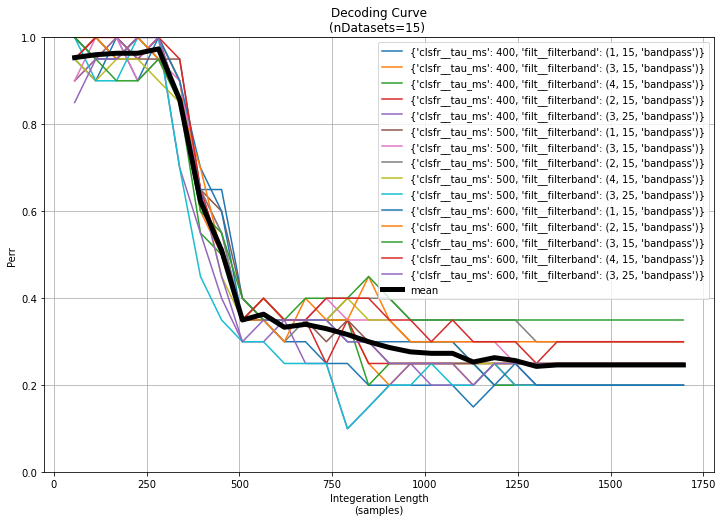



{'clsfr__tau_ms': 500, 'filt__filterband': (3, 25, 'bandpass')}

            IntLen   226   452   621   848  1074  1243  1469  1696 
              Perr  1.00  0.35  0.25  0.15  0.20  0.20  0.20  0.20   AUDC 36.7
         Perr(est)  1.00  0.27  0.19  0.17  0.14  0.12  0.11  0.12   PSAE 45.7
           StopErr  0.70  0.35  0.25  0.20  0.20  0.20  0.20  0.20   AUSC 31.8
     StopThresh(P)  0.58  0.26  0.13  0.11  0.11  0.11  0.11  0.11   SSAE 61.0



{'clsfr__tau_ms': 400, 'filt__filterband': (3, 25, 'bandpass')}

            IntLen   226   452   621   848  1074  1243  1469  1696 
              Perr  0.95  0.40  0.35  0.15  0.20  0.25  0.20  0.20   AUDC 37.7
         Perr(est)  1.00  0.27  0.22  0.17  0.12  0.13  0.11  0.11   PSAE 52.6
           StopErr  0.70  0.35  0.10  0.20  0.20  0.20  0.20  0.20   AUSC 29.7
     StopThresh(P)  0.55  0.20  0.08  0.11  0.11  0.11  0.11  0.11   SSAE 57.4



{'clsfr__tau_ms': 400, 'filt__filterband': (1, 15, 'bandpass')}

            IntLen   226   45

In [22]:
# Single Cell version: all fixed!

# default pipeline
fs_out=180
pipeline=[
    ['MetaInfoAdder',{'info':{'fs':fs, 'ch_names':ch_names}}],  #"TrialPlotter",
    "BadChannelRemover",
    ['ButterFilterAndResampler:filt',{'filterband':[3,25,'bandpass'], 'fs_out':100}],
    ['TargetEncoder',{'evtlabs':('onset','offset')}],
    ['MultiCCA:clsfr',{'tau_ms':450, 'temporal_basis':'winfourier2,10'}],
]

# run the search
# first make the base pipeline to run
ppp = make_preprocess_pipeline(pipeline)
print(ppp)

tuned_parameters={
    "clsfr__tau_ms":[400,500,600],
    "filt__filterband":[(1,15,'bandpass'),(2,15,'bandpass'),(3,15,'bandpass'),(4,15,'bandpass'),(3,25,'bandpass')],
}

# run this pipeline with all the settings.
# N.B. set n_jobs=1 for pipeline debugging as it gives more informative error messages and stops at first error
res = decoding_curve_GridSearchCV(ppp,X_TSd.copy(), Y_TSy.copy(), cv=5, 
                                  n_jobs=4, 
                                  tuned_parameters=tuned_parameters,
                                  cv_clsfr_only=False)
    
plt.figure()
plot_decoding_curves(res['decoding_curve'],labels=res['config'])
plt.show(block=True)

for si in np.argsort(res['audc']):
    dc,conf = (res['decoding_curve'][si],res['config'][si])
    print("\n\n{}\n".format(conf))
    print(print_decoding_curve(*dc))


The res produced in this case, is a dict with lots of interesting keys.   Structurely, each key contains a list of values, where each entry is the value of this key for the same configuration setting.  

Keys of particular interest are:
  * 'config' : which is the configuration for this run
  * 'decoding_curve' : which has the decoding curve information for this run
  * 'score' : the score for this run

We'd like to see the per-configuration decoding curves.  So we just plot them, with the config as label thusly:

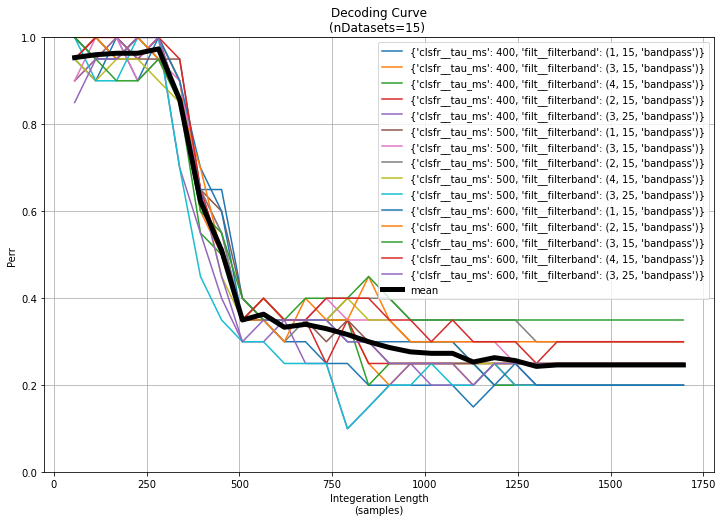



{'clsfr__tau_ms': 500, 'filt__filterband': (3, 25, 'bandpass')}

            IntLen   226   452   621   848  1074  1243  1469  1696 
              Perr  1.00  0.35  0.25  0.15  0.20  0.20  0.20  0.20   AUDC 36.7
         Perr(est)  1.00  0.27  0.19  0.17  0.14  0.12  0.11  0.12   PSAE 45.7
           StopErr  0.70  0.35  0.25  0.20  0.20  0.20  0.20  0.20   AUSC 31.8
     StopThresh(P)  0.58  0.26  0.13  0.11  0.11  0.11  0.11  0.11   SSAE 61.0



{'clsfr__tau_ms': 400, 'filt__filterband': (3, 25, 'bandpass')}

            IntLen   226   452   621   848  1074  1243  1469  1696 
              Perr  0.95  0.40  0.35  0.15  0.20  0.25  0.20  0.20   AUDC 37.7
         Perr(est)  1.00  0.27  0.22  0.17  0.12  0.13  0.11  0.11   PSAE 52.6
           StopErr  0.70  0.35  0.10  0.20  0.20  0.20  0.20  0.20   AUSC 29.7
     StopThresh(P)  0.55  0.20  0.08  0.11  0.11  0.11  0.11  0.11   SSAE 57.4



{'clsfr__tau_ms': 400, 'filt__filterband': (1, 15, 'bandpass')}

            IntLen   226   45

dict_keys(['score', 'audc', 'psae', 'ausc', 'ssae', 'decoding_curve', 'Fy', 'config', 'clsfr'])

In [23]:
plt.figure()
plot_decoding_curves(res['decoding_curve'],labels=res['config'])
plt.show(block=True)

for si in np.argsort(res['audc']):
    dc,conf = (res['decoding_curve'][si],res['config'][si])
    print("\n\n{}\n".format(conf))
    print(print_decoding_curve(*dc))
    #plt.figure()
    #plot_decoding_curve(*dc,title=conf)
res.keys()

# cross-session analysis

So far we have just run the analysis on a single, previously loaded dataset.  However, to get a real feeling for the importance of different settings, we need to compare them over multiple files recorded at different times for different subjects.  

For more information on how to do this type of analysis see the notebook `analyse_datasets_tutorial.ipynb`

To make this easier to perform, a equivalent function called `datasets_decoding_curve_GridsearchCV` is provided for running a GridsearchCV over multiple data sets.

To use this function, you must provide a file-loader function and a set of file-names to process.  The `datasets.py` file contains `get_dataset` method for getting these objects.

To get all the `mindaffectBCI` files in the `mark` with `noisetag` in the name use:

# Conclusion

We have shown how to use a pipeline to specify a preprocessing pipeline, and how to use the model-selection tools to test different parameter settings in a systematic way within a single dataset.